# Part 1. Prep before Scraping

## 1.1 Install the BS4 package if you havent already
pulling data out of HTML and XML files.

In [1]:
#!pip install bs4

## 1.2 Create an User-Agent 
avoid getting blocked

In [2]:
# user-gent from website: https://developers.whatismybrowser.com/
HEADERS = ({'User-Agent':
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/95.0.4638.69 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'})

In [3]:
# store the scraped deals
deals_list = []

# the product interested in
searchterm = 'ergonomic+vertical+wireless+mouse'

# link of the website
url = f'https://www.amazon.com/s?k={searchterm}&ref=nb_sb_noss'

# Part 2: Scraping Product Details

## 2.1 Request html information, parse into soup

In [4]:
# define a function to get the html content from the webpage
import requests
from bs4 import BeautifulSoup

def getdata(url):
  page = requests.get(url, headers=HEADERS)
  soup = BeautifulSoup(page.content, "html.parser")
  return soup

#getdata(url) get the page content

##2.2 Scrape product details on product title, link, price, coupons, stars ratings

In [5]:
def get_deals(soup):
  product = soup.find_all('div',{'data-component-type':'s-search-result'})

  for item in product:
        check = item.find_all('span',{'class':'a-offscreen'})
        if check != []:
          # title
          title = item.find('a',{'class':'a-link-normal a-text-normal'}).text.strip()[:25]
          #link
          link = item.find('a',{'class':'a-link-normal a-text-normal'})['href']
        
          #sale price and original price
          try:
            sale_price = float(item.find_all('span',{"class":'a-offscreen'})[0].text.replace('$','').replace(',','').strip())
            old_price = float(item.find_all('span',{"class":'a-offscreen'})[1].text.replace('$','').replace(',','').strip())
          except:
            old_price = float(item.find('span',{"class":'a-offscreen'}).text.replace('$','').replace(',','').strip())

          # coupon availability
          try:
            coupon = item.find('span',{'class':"a-size-base s-highlighted-text-padding aok-inline-block s-coupon-highlight-color"}).text.strip()
          except:
            coupon = 'no coupon'


          #number of reviews
          try:
            review = float(item.find('span',{"class":'a-size-base'}).text.strip())
          except:
            review = 0

          # star ratings
          try:
            rating = item.find('span',{"class":'a-icon-alt'}).text.strip()[:3]
          except:
            rating = None
        
          # create a dictionary to get all the information above
          saleitem = {
            'title':title,
            'link':link,
            'sale_price':sale_price,
            'old_price':old_price,
            'coupon':coupon,
            'review': review,
            'star_ratings': rating
            }
          deals_list.append(saleitem)
  return

## 2.3 Get product details page by page

In [6]:
# a definition that allows auto page flip 
def getnextpage(soup):
    page = soup.find('ul',attrs={"class":'a-pagination'})
    if page.find('li',attrs={"class":'a-last'}).find('a'):
      url = 'http://www.amazon.com'+ str(page.find('li',{"class":'a-last'}).find('a')['href'])
      return url
    else:
      return

##2.4 Save product details into a dataframe

In [7]:
import time

while True:
  soup = getdata(url)
  get_deals(soup)
  url = getnextpage(soup)
  if not url:
    break
  else:
    print(url)
    print(len(deals_list))
  time.sleep(1)
    

http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=2&qid=1638547746&ref=sr_pg_1
22
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=3&qid=1638547748&ref=sr_pg_2
44
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=4&qid=1638547751&ref=sr_pg_3
66
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=5&qid=1638547753&ref=sr_pg_4
86
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=6&qid=1638547755&ref=sr_pg_5
108
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=7&qid=1638547758&ref=sr_pg_6
130
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=8&qid=1638547760&ref=sr_pg_7
152
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=9&qid=1638547762&ref=sr_pg_8
174
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=10&qid=1638547764&ref=sr_pg_9
195
http://www.amazon.com/s?k=ergonomic+vertical+wireless+mouse&page=11&qid=1638547767&ref=sr_pg_10
216
http://www.amazon.com

In [8]:
import pandas as pd
df = pd.DataFrame(deals_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         409 non-null    object 
 1   link          409 non-null    object 
 2   sale_price    409 non-null    float64
 3   old_price     409 non-null    float64
 4   coupon        409 non-null    object 
 5   review        409 non-null    float64
 6   star_ratings  387 non-null    object 
dtypes: float64(3), object(4)
memory usage: 22.5+ KB


In [9]:
# the final price need to pay
import re as re
df['final_price'] = ""
for i in range(len(df)):
  if '$' in df['coupon'][i]: 
    df['final_price'][i] = df['sale_price'][i] - float(re.findall(r'[0-9]+',str(df['coupon'][i]))[0])

  elif '%' in df['coupon'][i]:
    df['final_price'][i] = df['sale_price'][i] * (100- float(re.findall(r'[0-9]+',str(df['coupon'][i]))[0]))/100
  else:
    df['final_price'][i] = df['sale_price'][i]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# how much percent off?
df['percentoff'] = 100*(df.old_price - df.final_price)/df.old_price
df = df.sort_values(by=['percentoff'], ascending=False)
df.head()

,title,link,sale_price,old_price,coupon,review,star_ratings,final_price,percentoff
263,"EVGA X17 Gaming Mouse, Wi",/EVGA-Customizable-Profiles-Ergonomic-903-W1-1...,29.99,79.99,no coupon,255.0,4.2,29.99,62.5078
245,"EVGA X17 Gaming Mouse, Wi",/EVGA-Customizable-Profiles-Ergonomic-903-W1-1...,29.99,79.99,no coupon,255.0,4.2,29.99,62.5078
202,Logitech G604 LIGHTSPEED,/Logitech-LIGHTSPEED-programmable-connectivity...,44.99,99.99,no coupon,0.0,4.5,44.99,55.0055
161,Adesso iMouse E10 - Verti,/Adesso-iMouse-E10-Ergonomic-Orientation/dp/B0...,19.25,39.99,no coupon,282.0,4.2,19.25,51.863
98,Actto Wireless Vertical E,/Wireless-Vertical-Ergonomic-Adjustable-Comput...,10.50,20.99,no coupon,3.0,4.6,10.5,49.9762


In [11]:
# remove duplicate rows
df = df.drop_duplicates(subset =['title','sale_price','old_price','final_price'])
#df.info()
df['star_ratings'] = df['star_ratings'].astype(float)
df['final_price'] = df['final_price'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264 entries, 263 to 179
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         264 non-null    object 
 1   link          264 non-null    object 
 2   sale_price    264 non-null    float64
 3   old_price     264 non-null    float64
 4   coupon        264 non-null    object 
 5   review        264 non-null    float64
 6   star_ratings  245 non-null    float64
 7   final_price   264 non-null    float64
 8   percentoff    264 non-null    object 
dtypes: float64(5), object(4)
memory usage: 20.6+ KB


In [12]:
# how much money discounted?
df['dollaroff'] = df.old_price - df.final_price

df = df.sort_values(by=['dollaroff'], ascending=False)
df.head()

,title,link,sale_price,old_price,coupon,review,star_ratings,final_price,percentoff,dollaroff
139,Carpal Tunnel Mouse Wrist,/Ergonomics-QuadraClicks-Recommended-Numbness-...,114.86,149.99,Save $25.00,51.0,4.0,89.86,40.0893,60.13
202,Logitech G604 LIGHTSPEED,/Logitech-LIGHTSPEED-programmable-connectivity...,44.99,99.99,no coupon,0.0,4.5,44.99,55.0055,55.00
337,Razer Basilisk Ultimate H,/Razer-Basilisk-Ultimate-HyperSpeed-Wireless/d...,119.99,169.99,no coupon,0.0,4.7,119.99,29.4135,50.00
240,Logitech G502 Lightspeed,/Logitech-Lightspeed-PowerPlay-Compatible-Ligh...,99.99,149.99,no coupon,0.0,4.7,99.99,33.3356,50.00
263,"EVGA X17 Gaming Mouse, Wi",/EVGA-Customizable-Profiles-Ergonomic-903-W1-1...,29.99,79.99,no coupon,255.0,4.2,29.99,62.5078,50.00


In [13]:
# save everything into a csv file


# Part 3 Plotting distribution

## 3.1.1 Sale Price distribution



The average sale price of the vertical mouse is $ 39.63


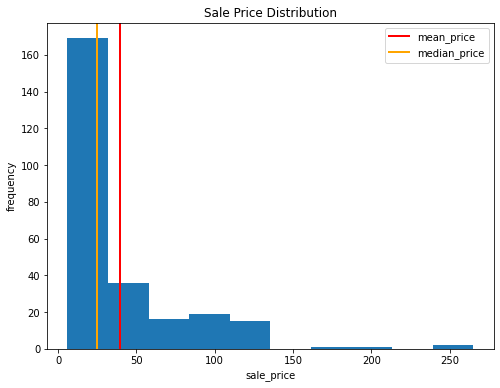

In [14]:
import matplotlib.pyplot as plt
import numpy as np

#avg sale price
avg_sale_price = round(np.mean(df['sale_price']),2)
print('The average sale price of the vertical mouse is $',avg_sale_price)

plt.figure(figsize=(8,6))

plt.hist(df['sale_price'])
plt.axvline(df['sale_price'].mean(), color='red', linewidth=2, label='mean_price')
plt.axvline(df['sale_price'].median(), color='orange', linewidth=2, label='median_price')
plt.legend(loc='upper right')

plt.xlabel('sale_price')
plt.ylabel('frequency')
plt.title('Sale Price Distribution')
plt.legend(loc='upper right')
plt.show()

In [15]:
import numpy as np 
conditions = [(df['sale_price']<df['sale_price'].mean()),
         (df['sale_price']>=df['sale_price'].mean()) & (df['sale_price']<=60),
         (df['sale_price']>1.5*df['sale_price'].median())]

value = ['low','median','high']

df['group_price'] = np.select(conditions,value)

In [16]:
print(df[df['group_price']=='low']['review'].mean())
print(df[df['group_price']=='median']['review'].mean())
print(df[df['group_price']=='high']['review'].mean())

147.34972677595627
74.0
91.5


## 3.1.2 Final Price distribution 

The average final price of vertical mouse is $ 38.93 dollar


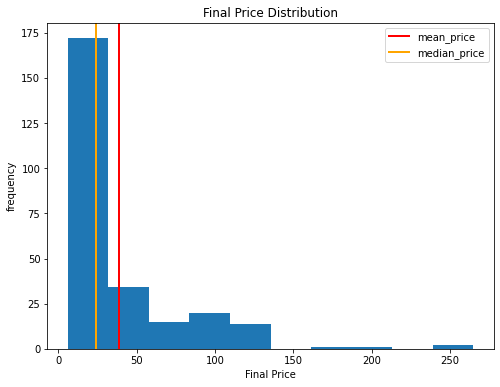

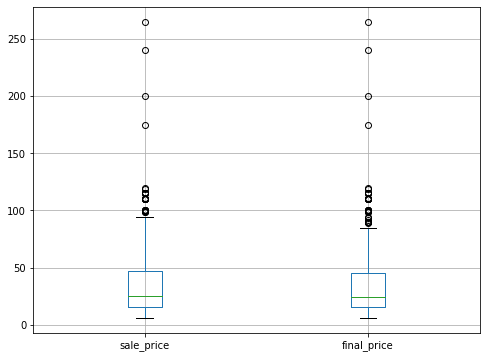

In [17]:
# the average final price
avg_final_price = round(np.mean(df['final_price']),2)
print('The average final price of vertical mouse is $',avg_final_price,'dollar')

plt.figure(figsize=(8,6))
plt.hist(df['final_price'])
plt.axvline(df['final_price'].mean(), color='red', linewidth=2, label='mean_price')
plt.axvline(df['final_price'].median(), color='orange', linewidth=2, label='median_price')
plt.legend(loc='upper right')

plt.xlabel('Final Price')
plt.ylabel('frequency')
plt.title('Final Price Distribution')
plt.show()

# the boxplot
plt.figure(figsize=(8,6))
df.boxplot(['sale_price','final_price'])

## 3.1.3 Ratings 


The average ratingof vertical mouse is 4.2 stars out of 5.0


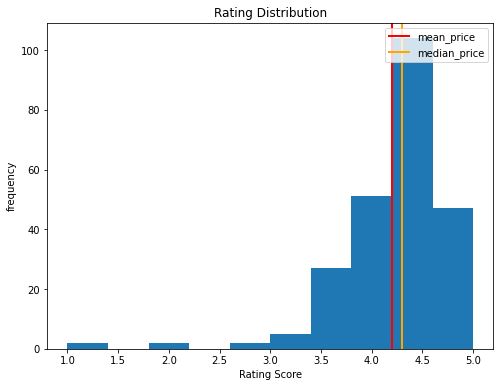

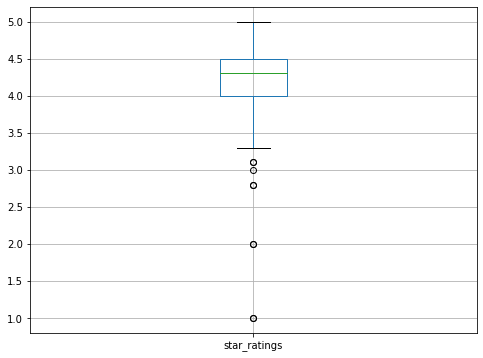

In [18]:
# the average star rating
avg_rating= round(np.mean(df['star_ratings']),2)
print('The average ratingof vertical mouse is',avg_rating,'stars out of 5.0')

plt.figure(figsize=(8,6))
plt.hist(df['star_ratings'])
plt.axvline(df['star_ratings'].mean(), color='red', linewidth=2, label='mean_price')
plt.axvline(df['star_ratings'].median(), color='orange', linewidth=2, label='median_price')
plt.legend(loc='upper right')


plt.xlabel('Rating Score')
plt.ylabel('frequency')
plt.title('Rating Distribution')
plt.show()

# the boxplot
plt.figure(figsize=(8,6))
df.boxplot(column=['star_ratings'])

##3.2 Filter the Vertical Mouse I want and save it in a new df
I am interested in Ergonomic Mouse that is 
1. Greater than the median but Lower than 100
2. Ratings Higher than the average star ratings
3. Having at least 100 number of reviews so that I can scan through customer reviews
4. number of review greater than the average 

In [14]:
# the final dataset after filtering out the three criteria, we have 10 entries left off
df_final = df[(df['final_price']<=60) &
              (df['final_price']>=20) &
              (df['star_ratings']>df['star_ratings'].median()) &
              (df['review']>df['review'].mean())]
#df_final

# rank the final by star rating
df_final = df_final.sort_values(by=['star_ratings'], ascending=False)
df_final

,title,link,sale_price,old_price,coupon,review,star_ratings,final_price,percentoff,dollaroff
144,"Perixx Perimice-719L, Lef",/Perixx-Perimice-719L-Wireless-Vertical-Portab...,21.99,21.99,no coupon,589.0,4.6,21.9900,0,0.0000
369,Verbatim 2.4G Wireless 8-,/Verbatim-Wireless-Desktop-8-Button-Deluxe/dp/...,24.99,36.00,no coupon,287.0,4.5,24.9900,30.5833,11.0100
34,ECHTPower Rechargeable Er,/ECHTPower-Rechargeable-Ergonomic-Mouse-Reduce...,23.99,23.99,Save 15%,340.0,4.5,20.3915,15,3.5985
13,"Ergonomic Mouse, seenda W",/Ergonomic-Mouse-seenda-Wireless-Vertical/dp/B...,26.98,26.98,Save 5%,493.0,4.5,25.6310,5,1.3490
88,DELUX Wireless Ergonomic,/Ergonomic-Wireless-Rechargeable-Vertical-M618...,35.99,37.99,Save 10%,336.0,4.4,32.3910,14.7381,5.5990
352,Microsoft Sculpt Ergonomi,/Microsoft-Sculpt-Ergonomic-Mouse-L6V-00002/dp...,54.99,59.95,no coupon,324.0,4.4,54.9900,8.27356,4.9600
70,J-Tech Digital Vertical E,/J-Tech-Digital-Ergonomic-Adjustable-V628R/dp/...,29.95,29.95,Save 5%,558.0,4.4,28.4525,5,1.4975
5,J-Tech Digital Ergonomic,/J-Tech-Digital-Connection-Rechargeable-V638/d...,28.95,28.95,Save 5%,680.0,4.4,27.5025,5,1.4475
9,Ergonomic Vertical Mouse,/Ergonomic-Vertical-Computer-Adjustable-Remova...,25.99,25.99,no coupon,348.0,4.4,25.9900,0,0.0000
157,Adesso iMouseE1 - Vertica,/Adesso-iMouseE1-Ergonomic-Illuminated-Orienta...,28.89,28.89,no coupon,293.0,4.4,28.8900,0,0.0000


#Part 4. Extract Product Information



In [16]:
pd.set_option('display.max_colwidth', None)
df_final2 = df_final[['title','link','old_price','final_price','star_ratings']]

df_final2['link'] = "http://www.amazon.com"+df_final2['link']
df_final2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,title,link,old_price,final_price,star_ratings
144,"Perixx Perimice-719L, Lef",http://www.amazon.com/Perixx-Perimice-719L-Wireless-Vertical-Portable/dp/B07SSD86LT/ref=sr_1_111?keywords=ergonomic+vertical+wireless+mouse&qid=1638547760&sr=8-111,21.99,21.9900,4.6
369,Verbatim 2.4G Wireless 8-,http://www.amazon.com/Verbatim-Wireless-Desktop-8-Button-Deluxe/dp/B00YHU0W16/ref=sr_1_281?keywords=ergonomic+vertical+wireless+mouse&qid=1638547784&sr=8-281,36.00,24.9900,4.5
34,ECHTPower Rechargeable Er,http://www.amazon.com/ECHTPower-Rechargeable-Ergonomic-Mouse-Reduce-Adjustable/dp/B07M6P9TW6/ref=sr_1_29?keywords=ergonomic+vertical+wireless+mouse&qid=1638547748&sr=8-29,23.99,20.3915,4.5
13,"Ergonomic Mouse, seenda W",http://www.amazon.com/Ergonomic-Mouse-seenda-Wireless-Vertical/dp/B08LVJSX3T/ref=sr_1_14?keywords=ergonomic+vertical+wireless+mouse&qid=1638547746&sr=8-14,26.98,25.6310,4.5
88,DELUX Wireless Ergonomic,http://www.amazon.com/Ergonomic-Wireless-Rechargeable-Vertical-M618mini-Pearl-like/dp/B07NZ4GJ9W/ref=sr_1_67?keywords=ergonomic+vertical+wireless+mouse&qid=1638547755&sr=8-67,37.99,32.3910,4.4
352,Microsoft Sculpt Ergonomi,http://www.amazon.com/Microsoft-Sculpt-Ergonomic-Mouse-L6V-00002/dp/B00DUV01RS/ref=sr_1_270?keywords=ergonomic+vertical+wireless+mouse&qid=1638547782&sr=8-270,59.95,54.9900,4.4
70,J-Tech Digital Vertical E,http://www.amazon.com/J-Tech-Digital-Ergonomic-Adjustable-V628R/dp/B07P9CFRKS/ref=sr_1_54?keywords=ergonomic+vertical+wireless+mouse&qid=1638547753&sr=8-54,29.95,28.4525,4.4
5,J-Tech Digital Ergonomic,http://www.amazon.com/J-Tech-Digital-Connection-Rechargeable-V638/dp/B084JL59XV/ref=sr_1_6?keywords=ergonomic+vertical+wireless+mouse&qid=1638547746&sr=8-6,28.95,27.5025,4.4
9,Ergonomic Vertical Mouse,http://www.amazon.com/Ergonomic-Vertical-Computer-Adjustable-Removable/dp/B083TP2FHZ/ref=sr_1_10?keywords=ergonomic+vertical+wireless+mouse&qid=1638547746&sr=8-10,25.99,25.9900,4.4
157,Adesso iMouseE1 - Vertica,http://www.amazon.com/Adesso-iMouseE1-Ergonomic-Illuminated-Orientation/dp/B00GN0WL30/ref=sr_1_118?keywords=ergonomic+vertical+wireless+mouse&qid=1638547762&sr=8-118,28.89,28.8900,4.4


In [17]:
df[df['title'] == 'ASOI DOOMIER 2.4G Wireles']

,title,link,sale_price,old_price,coupon,review,star_ratings,final_price,percentoff,dollaroff
16,ASOI DOOMIER 2.4G Wireles,/gp/slredirect/picassoRedirect.html/ref=pa_sp_mtf_aps_sr_pg1_1?ie=UTF8&adId=A0430937ZYXAQY8R6KS8&url=%2FWireless-Vertical-Ergonomic-Adjustable-Performance%2Fdp%2FB0836J7K52%2Fref%3Dsr_1_17_sspa%3Fkeywords%3Dergonomic%2Bvertical%2Bwireless%2Bmouse%26qid%3D1638547746%26sr%3D8-17-spons%26psc%3D1%26smid%3DA1PVZ33AR618I8&qualifier=1638547746&id=2281163136919549&widgetName=sp_mtf,22.99,22.99,Save 20%,952.0,4.2,18.392,20,4.598


# Part 5. Sending Email for recommendation

In [35]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
# sending e-mail
def send_mail(body):

    message = MIMEMultipart()
    message['Subject'] = """Don't Miss out! Top Selected Mouse For You"""
    message['From'] = 'jonedoe@gmail.com'
    message['To'] = 'jonedoe@gmail.com'

    body_content = body
    message.attach(MIMEText(body_content, "html"))
    msg_body = message.as_string()

    server = SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(message['From'], 'YourPassword')
    server.sendmail(message['From'], message['To'], msg_body)
    server.quit()

In [24]:
!pip install pretty_html_table

In [37]:
from pretty_html_table import build_table

def send_mouse_list():
    mouse_list = build_table(df_final2, 'blue_light')
    msg = """<p> Hi, Floy! </p>
    <p> This is the recommendation of the mouse you want. They all have at least 100 reviews, 
    price range between $25~$80, and are at least rated higher than the average customer star ratings. 
    Lets get the right mouse for you :)</p> 
    <p> Have a wonderful day! </p> <br></br>""" + mouse_list
    send_mail(msg)
    return "Mail sent successfully."


send_mouse_list()

'Mail sent successfully.'